# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['PARTY', 'NEW', 'BUY1', 'BLUE', 'NEXT-WEEK', 'GIRL', 'GIVE', 'FISH', 'STUDENT', 'BLAME', 'PAST', 'LEG', 'GO1', 'HIT', 'MOVIE', 'SHOOT', 'LOVE', 'HOMEWORK', 'SEE', 'READ', 'HOUSE', 'OLD', 'BROTHER', 'CHINA', 'FRANK', 'STOLEN', 'SELF', 'CAR', 'MAN', 'DECIDE', 'LIVE', 'BOX', 'CORN', 'SOMETHING-ONE', 'PUTASIDE', 'POSS', 'SHOULD', 'GIVE3', 'ALL', 'WHO', 'FRIEND', 'POTATO', 'FUTURE', 'CORN1', 'SAY', 'TOY1', 'LIKE', 'GIVE1', 'PEOPLE', 'IX', 'CANDY', 'VISIT', 'NAME', 'BORROW', 'WONT', 'LEAVE', 'WHAT', 'BREAK-DOWN', 'CHICKEN', 'BUT', 'IX-1P', 'TEACHER', 'SEARCH-FOR', 'CHOCOLATE', 'FRED', 'SUE', 'NOT', 'BOOK', 'WOMAN', 'APPLE', 'WRITE', 'GET', 'VIDEOTAPE', 'KNOW', 'HERE', 'GIVE2', 'ANN', 'ARRIVE', 'FINISH', 'NEW-YORK', 'JOHN', 'WANT', 'GO', 'SAY-1P', 'SELL', 'MANY', 'THROW', 'BUY', 'MOTHER', 'FIND', 'JANA', 'HAVE', 'BILL', 'BROCCOLI', 'BOY', 'LAST-WEEK', 'CAN', 'TOMORROW', 'GO2', 'CHICAGO', 'THINK', 'PREFER', 'FUTURE1', 'TELL', 'YESTERDAY', 'EAT', 'COAT', 'VEGETABLE', 'TOY', 'GR

In [7]:
#training._data

In [8]:
#training._hmm_data 

In [9]:
training.num_items

112

In [25]:
training.words
training.words[0:10]

['PARTY',
 'NEW',
 'BUY1',
 'BLUE',
 'NEXT-WEEK',
 'GIRL',
 'GIVE',
 'FISH',
 'STUDENT',
 'BLAME']

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [11]:
 # X: is a numpy array of feature lists and 
# lengths: is a list of lengths of sequences within X
X, lengths = training.get_word_Xlengths('CHOCOLATE')
#lengths

In [12]:
X.shape[1]
#len(X[0])

4

In [13]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [14]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [15]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [16]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [17]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

asl.df['left-y-mean']= asl.df['speaker'].map(df_means['left-y'])
asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x'])
asl.df['right-y-mean']= asl.df['speaker'].map(df_means['right-y'])

asl.df['left-x-std']= asl.df['speaker'].map(df_std['left-x'])
asl.df['left-y-std']= asl.df['speaker'].map(df_std['left-y'])
asl.df['right-x-std']= asl.df['speaker'].map(df_std['right-x'])
asl.df['right-y-std']= asl.df['speaker'].map(df_std['right-y'])


asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['right-x-mean'])/asl.df['right-x-std']
asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['right-y-mean'])/asl.df['right-y-std']
asl.df['norm-lx'] = (asl.df['left-x'] - asl.df['left-x-mean'])/asl.df['left-x-std']
asl.df['norm-ly'] = (asl.df['left-y'] - asl.df['left-y-mean'])/asl.df['left-y-std']


features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [18]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle
asl.df['polar-rr'] = np.sqrt(asl.df['grnd-rx']**2 + asl.df['grnd-ry']**2)
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])

asl.df['polar-lr'] = np.sqrt(asl.df['grnd-lx']**2 + asl.df['grnd-ly']**2)
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [19]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'
asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(0)
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(0)
asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(0)
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(0)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [20]:
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly    ...      norm-lx   norm-ly  \
video frame                               ...                          
98    0          113        9      119    ...    -0.891199  0.741835   
      1          113        9      119    ...    -0.891199  0.741835   
      2          113        9      119    ...    -0.891199  0.741835   
      3          113        9      119    ...    -0.891199  0.741835   
      4          113        9      119    ...    -0.891199  0.741835   

              polar-rr  polar-rtheta    polar-lr  polar-ltheta  delta-rx  \
video frame                                                                
98    0      113.35784      0.079478  119.603512     -0.100501       0.0   
      1      113.35784      0.079478  119.603512     -0.100501       0.0   
      2      113.35784      0.079478  119.603512     -0.100501       0.0   
      3      113.35784      0.079478  119.603512     -0.100501       0.0   
      4      113.35784      0.079478  119.603512     -0.100501       0.0   

             delta-ry  delta-lx  delta-ly  
video frame                                
98    0           0.0       0.0       0.0  
      1           0.0       0.0       0.0  
      2           0.0       0.0       0.0  
      3           0.0       0.0       0.0  
      4           0.0       0.0       0.0  

[5 rows x 31 columns]

In [21]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

df_max = asl.df.groupby('speaker').max()
df_min = asl.df.groupby('speaker').min()

def rescaling_norm(row, col):
    return (row[col] - df_min.loc[row["speaker"]][col]) / ( df_max.loc[row["speaker"]][col] - 
                                                           df_min.loc[row["speaker"]][col])


asl.df['rescaling-rx'] = asl.df.apply(rescaling_norm, args=("grnd-rx",), axis=1)
asl.df['rescaling-ry'] = asl.df.apply(rescaling_norm, args=("grnd-ry",), axis=1)
asl.df['rescaling-lx'] = asl.df.apply(rescaling_norm, args=("grnd-lx",), axis=1)
asl.df['rescaling-ly'] = asl.df.apply(rescaling_norm, args=("grnd-ly",), axis=1)

features_rescaling_norm = ['rescaling-rx', 'rescaling-ry', 'rescaling-lx', 'rescaling-ly']

# delta differences between two hands in normalized Cartesian coordinates
asl.df['delta-norm-x'] = asl.df['norm-rx'] - asl.df['norm-lx']
asl.df['delta-norm-y'] = asl.df['norm-ry'] - asl.df['norm-ly']

features_delta_norm = ['delta-norm-x', 'delta-norm-y']

# TODO define a list named 'features_custom' for building the training set

features_custom =  features_delta_norm + features_rescaling_norm 

In [22]:
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly      ...       delta-rx  delta-ry  \
video frame                                 ...                            
98    0          113        9      119      ...            0.0       0.0   
      1          113        9      119      ...            0.0       0.0   
      2          113        9      119      ...            0.0       0.0   
      3          113        9      119      ...            0.0       0.0   
      4          113        9      119      ...            0.0       0.0   

             delta-lx  delta-ly  rescaling-rx  rescaling-ry  rescaling-lx  \
video frame                                                                 
98    0           0.0       0.0      0.683761      0.921986      0.154639   
      1           0.0       0.0      0.683761      0.921986      0.154639   
      2           0.0       0.0      0.683761      0.921986      0.154639   
      3           0.0       0.0      0.683761      0.921986      0.154639   
      4           0.0       0.0      0.683761      0.921986      0.154639   

             rescaling-ly  delta-norm-x  delta-norm-y  
video frame                                            
98    0          0.830189      2.044431      0.921597  
      1          0.830189      2.044431      0.921597  
      2          0.830189      2.044431      0.921597  
      3          0.830189      2.044431      0.921597  
      4          0.830189      2.044431      0.921597  

[5 rows x 37 columns]

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**

- rescaling normalization radius in Cartesian coordinates 

Rescaling normalization requires less computation. And for human actions, most of data sets don't have outliers. So given these two reasons, features normalized by rescaling is a good choice.
 
- delta difference norm between two hands

it's differences between two hands in normalized Cartesian coordinates

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [23]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.016s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [26]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    print("List of lengths of sequences within X is {}".format(lengths))
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

List of lengths of sequences within X is [6, 6, 7, 7, 11, 8, 8, 8, 7, 8, 17, 15, 13, 14, 11, 8, 10, 8]
Number of states trained in model for BOOK is 3
logL = -2331.1138127433187


List of lengths of sequences within X is [6, 6, 7, 7, 11, 8, 8, 8, 7, 8, 17, 15, 13, 14, 11, 8, 10, 8]

- hidden state #0 : 6, 6, 7, 7 (including 4 segments , 1st segment consists of 6 features, etc)

- hidden state #1 : 11, 8, 8, 8 (including 4 segments , 1st segment consists of 11 features, etc)
 
- hidden state #2 : 7, 8, 17, 15 (including 4 segments , 1st segment consists of 7 features, etc)


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [27]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [28]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

List of lengths of sequences within X is [17, 20, 12]
Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057775]
variance =  [ 16.16920957  46.50917372   3.81388185  15.79446427]

hidden state #1
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #2
mean =  [ -5.40587658  60.1652424    2.32479599  91.3095432 ]
variance =  [   7.95073876   64.13103127   13.68077479  129.5912395 ]

logL = -601.329147002863


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [29]:
%matplotlib inline
import seaborn as sns

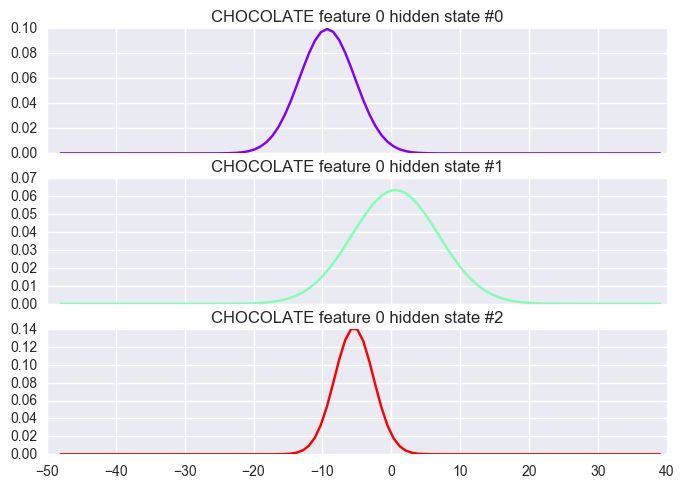

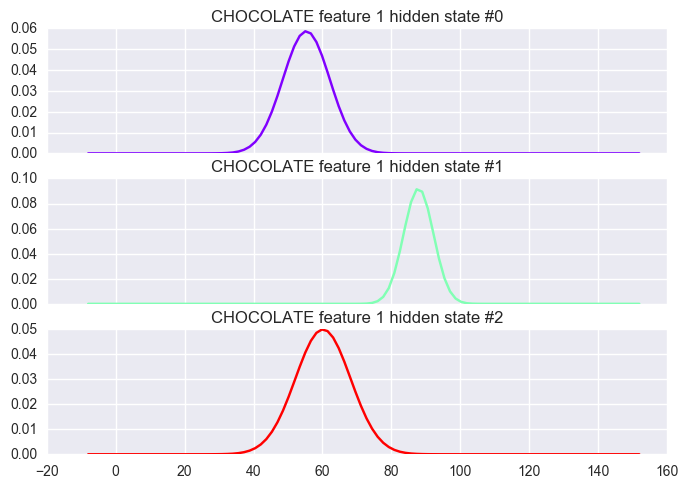

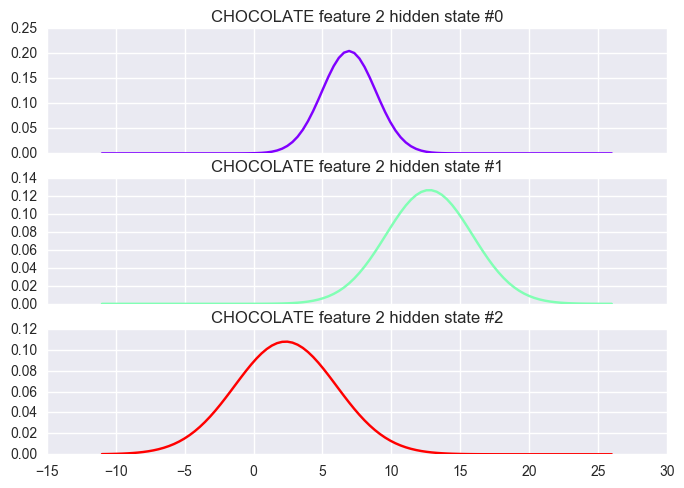

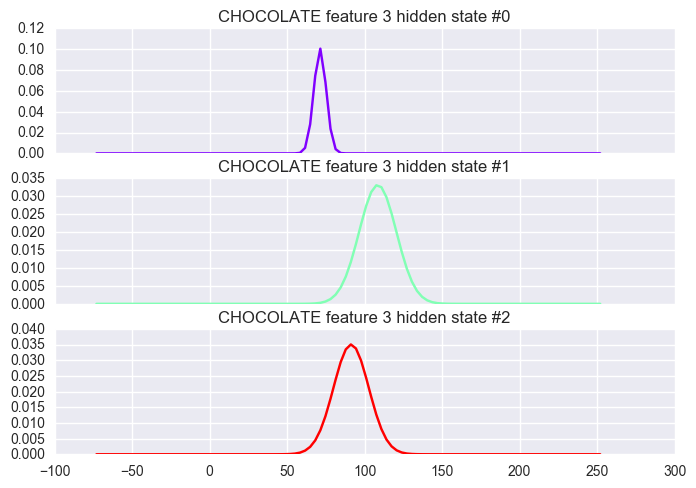

In [30]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `SelectorModel` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [31]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


In [32]:
training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'CHICAGO' 
#word = 'BREAK-DOWN' 
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for CHICAGO is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [33]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
#word = 'CHICAGO' 
#word = 'BREAK-DOWN' 
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [34]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [35]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.3715307540005597 seconds
Training complete for BOOK with 6 states with time 3.9419054110003344 seconds
Training complete for VEGETABLE with 2 states with time 1.5496413330001815 seconds
Training complete for FUTURE with 2 states with time 4.021299783998984 seconds
Training complete for JOHN with 12 states with time 39.17455837400121 seconds


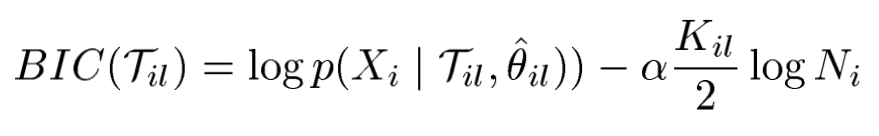

In [36]:
from IPython.display import Image
Image(filename='BIC.png')

In [37]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.29241850299877115 seconds
Training complete for BOOK with 3 states with time 1.741507795999496 seconds
Training complete for VEGETABLE with 3 states with time 0.625201865001145 seconds
Training complete for FUTURE with 3 states with time 1.8407085619983263 seconds
Training complete for JOHN with 3 states with time 18.182147600000462 seconds


In [38]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.28756961099861655 seconds
Training complete for BOOK with 15 states with time 1.966052783998748 seconds
Training complete for VEGETABLE with 15 states with time 0.686750059001497 seconds
Training complete for FUTURE with 15 states with time 2.072625105996849 seconds
Training complete for JOHN with 15 states with time 19.997719672999665 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

- SelectorCV selects the best model when training dataset is large enough. The disadvantage of SelectorCV is that it takes longer to find the best model


- SelectorBIC avoids overfitting by penalizing complexity, so it prefer a simpler model. The advantage of SelectBIC is that the computational time for model selection is faster  


- SelectorDIC outperforms SelectorBIC in terms of performance because it selects the word model that makes the word more distinctive to other words and the models can distinguish which word is more likely. However, the DIC exhibits a higher number of parameters than BIC, so the model selection process is rather slow.


<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [39]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 43.637s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [40]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [41]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [42]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors
from my_model_selectors import SelectorConstant, SelectorCV, SelectorBIC, SelectorDIC

In [43]:
# TODO Choose a feature set and model selector
features = features_ground # change as needed
model_selector = SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 66.85%
Total correct: 59 out of 178


66.85393258426966

### Features Polar vs  Models (Constant, CV, BIC, DIC)

In [44]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method

model_selectors = [SelectorConstant, SelectorCV, SelectorBIC, SelectorDIC]
features = features_polar 

test_set = asl.build_test(features)
for model_selector in model_selectors:
    print("{}:".format(model_selector.__name__))
    start = timeit.default_timer()
    models = train_all_words(features, model_selector)
    probabilities, guesses = recognize(models, test_set)
    _ = show_errors(guesses, test_set)
    end = timeit.default_timer()-start
    print("Completed in {:.2f} seconds".format(end))
    print("="*50)

SelectorConstant:

**** WER = 61.80%
Total correct: 68 out of 178
Completed in 17.45 seconds
SelectorCV:

**** WER = 61.24%
Total correct: 69 out of 178
Completed in 113.51 seconds
SelectorBIC:

**** WER = 61.80%
Total correct: 68 out of 178
Completed in 75.48 seconds
SelectorDIC:

**** WER = 55.06%
Total correct: 80 out of 178
Completed in 81.63 seconds


In [45]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method
model_selector =  SelectorDIC

features = {'features_ground' : features_ground}


for feature_name, feature in features.items():
    print("{}:".format(feature_name))
    start = timeit.default_timer()
    models = train_all_words(feature, model_selector)
    test_set = asl.build_test(feature)
    probabilities, guesses = recognize(models, test_set)
    _ = show_errors(guesses, test_set)
    end = timeit.default_timer()-start
    print("Completed in {:.2f} seconds".format(end))
    print("="*50)

features_ground:

**** WER = 58.99%
Total correct: 73 out of 178
Completed in 78.17 seconds


## SelectorConstant Model

In [46]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method
model_selectors = SelectorConstant


features = {'features_delta': features_delta, 
            'features_norm' : features_norm, 
            'features_delta_norm' : features_delta_norm, 
            'features_rescaling_norm' : features_rescaling_norm, 
            'features_polar' : features_polar, 
            'features_ground' : features_ground}


for feature_name, feature in features.items():
    print("{}".format(feature_name))
    start = timeit.default_timer()
    models = train_all_words(feature, model_selector)
    test_set = asl.build_test(feature)
    probabilities, guesses = recognize(models, test_set)
    _ = show_errors(guesses, test_set)
    end = timeit.default_timer()-start
    print("Completed in {:.2f} seconds".format(end))
    print("="*50)

features_rescaling_norm

**** WER = 52.81%
Total correct: 84 out of 178
Completed in 80.31 seconds
features_delta_norm

**** WER = 66.29%
Total correct: 60 out of 178
Completed in 85.99 seconds
features_norm

**** WER = 60.67%
Total correct: 70 out of 178
Completed in 77.61 seconds
features_ground

**** WER = 58.99%
Total correct: 73 out of 178
Completed in 75.98 seconds
features_delta

**** WER = 61.24%
Total correct: 69 out of 178
Completed in 88.73 seconds
features_polar

**** WER = 55.06%
Total correct: 80 out of 178
Completed in 84.14 seconds


## SelectorCV Model

In [51]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method
model_selector = SelectorCV


features = {'features_delta': features_delta, 
            'features_norm' : features_norm, 
            'features_delta_norm' : features_delta_norm, 
            'features_rescaling_norm' : features_rescaling_norm, 
            'features_polar' : features_polar, 
            'features_ground' : features_ground}


for feature_name, feature in features.items():
    print("{}".format(feature_name))
    start = timeit.default_timer()
    models = train_all_words(feature, model_selector)
    test_set = asl.build_test(feature)
    probabilities, guesses = recognize(models, test_set)
    _ = show_errors(guesses, test_set)
    end = timeit.default_timer()-start
    print("Completed in {:.2f} seconds".format(end))
    print("="*50)

features_rescaling_norm

**** WER = 62.36%
Total correct: 67 out of 178
Completed in 116.40 seconds
features_delta_norm

**** WER = 65.17%
Total correct: 62 out of 178
Completed in 140.30 seconds
features_norm

**** WER = 66.29%
Total correct: 60 out of 178
Completed in 121.42 seconds
features_ground

**** WER = 60.11%
Total correct: 71 out of 178
Completed in 107.44 seconds
features_delta

**** WER = 62.92%
Total correct: 66 out of 178
Completed in 112.59 seconds
features_polar

**** WER = 61.24%
Total correct: 69 out of 178
Completed in 117.20 seconds


## SelectorBIC Model

In [53]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method
model_selector = SelectorBIC

features = {'features_delta': features_delta, 
            'features_norm' : features_norm, 
            'features_delta_norm' : features_delta_norm, 
            'features_rescaling_norm' : features_rescaling_norm, 
            'features_polar' : features_polar, 
            'features_ground' : features_ground}


for feature_name, feature in features.items():
    print("{}".format(feature_name))
    start = timeit.default_timer()
    models = train_all_words(feature, model_selector)
    test_set = asl.build_test(feature)
    probabilities, guesses = recognize(models, test_set)
    _ = show_errors(guesses, test_set)
    end = timeit.default_timer()-start
    print("Completed in {:.2f} seconds".format(end))
    print("="*50)

features_rescaling_norm

**** WER = 65.73%
Total correct: 61 out of 178
Completed in 70.47 seconds
features_delta_norm

**** WER = 74.16%
Total correct: 46 out of 178
Completed in 77.23 seconds
features_norm

**** WER = 62.36%
Total correct: 67 out of 178
Completed in 70.20 seconds
features_ground

**** WER = 66.85%
Total correct: 59 out of 178
Completed in 66.53 seconds
features_delta

**** WER = 64.04%
Total correct: 64 out of 178
Completed in 80.46 seconds
features_polar

**** WER = 61.80%
Total correct: 68 out of 178
Completed in 73.52 seconds


## SelectorDIC Model

In [52]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method
model_selector =  SelectorDIC

features = {'features_delta': features_delta, 
            'features_norm' : features_norm, 
            'features_delta_norm' : features_delta_norm, 
            'features_rescaling_norm' : features_rescaling_norm, 
            'features_polar' : features_polar, 
            'features_ground' : features_ground}


for feature_name, feature in features.items():
    print("{}".format(feature_name))
    start = timeit.default_timer()
    models = train_all_words(feature, model_selector)
    test_set = asl.build_test(feature)
    probabilities, guesses = recognize(models, test_set)
    _ = show_errors(guesses, test_set)
    end = timeit.default_timer()-start
    print("Completed in {:.2f} seconds".format(end))
    print("="*50)

features_rescaling_norm

**** WER = 52.81%
Total correct: 84 out of 178
Completed in 75.77 seconds
features_delta_norm

**** WER = 66.29%
Total correct: 60 out of 178
Completed in 88.94 seconds
features_norm

**** WER = 60.67%
Total correct: 70 out of 178
Completed in 84.18 seconds
features_ground

**** WER = 58.99%
Total correct: 73 out of 178
Completed in 77.86 seconds
features_delta

**** WER = 61.24%
Total correct: 69 out of 178
Completed in 84.79 seconds
features_polar

**** WER = 55.06%
Total correct: 80 out of 178
Completed in 80.94 seconds


In [47]:
WER_table = pd.DataFrame(columns=["Constant", "CV","BIC", "DIC"])
WER_table.loc['features_delta'] = ["65.73%", "62.92%", "65.73%", "61.24%"]
WER_table.loc['features_norm'] = ["60.67%", "66.29%", "60.67%", "60.67%"]
WER_table.loc['features_delta_norm'] = ["66.85%", "65.17%", "66.85%", "66.29%"]
WER_table.loc['features_rescaling_norm'] = ["54.49%", "62.36%", "54.49%", "52.81%"]
WER_table.loc['features_polar'] = ["54.49%", "61.24%", "54.49%", "55.06%"]
WER_table.loc['features_ground'] = ["58.99%", "60.11%", "58.99%", "58.99%"]
WER_table

,Constant,CV,BIC,DIC
features_delta,65.73%,62.92%,65.73%,61.24%
features_norm,60.67%,66.29%,60.67%,60.67%
features_delta_norm,66.85%,65.17%,66.85%,66.29%
features_rescaling_norm,54.49%,62.36%,54.49%,52.81%
features_polar,54.49%,61.24%,54.49%,55.06%
features_ground,58.99%,60.11%,58.99%,58.99%


**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

Combination of SelectorBIC and features_delta_norm is the best combinations with WER 0.6685. While SelectorDIC and features_rescaling_norm is the worst combination with WER 0.5281.

To improve WER, we could take into account the conditional probability of a word given the previous one or two words obtained in our guessing sentence. We can also use the information about the probability of occurrence for each word and the probability of other adjacent words for avoiding underfitting. Due to the short lenght of our sentence 1-gram or 2-gram strategy will be useful.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [48]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 28.244s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [54]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-2484.074988,-1.597319e+05,-1652.469673,-156.839891,-444.856939,-159.314704,-2788.373706,-505.180268,-4494.410087,-280.046260,...,-670.810878,-123.797799,-761.870757,-219.362222,-117.948851,-1173.710978,-475.056958,-348.100642,-1505.038500,-175.064717
1,-6939.702319,-1.892720e+05,-2486.614481,-117.942556,-4022.546054,-126.607267,-2762.903680,-72.687008,-3834.421244,-429.570201,...,-83.006681,-177.438594,-784.880415,-383.856239,-158.210619,-4653.723059,-262.048851,-424.230028,-59.311849,-166.326143
2,-9803.604767,-6.821695e+05,-4669.737685,-258.415292,-4917.608151,-282.328253,-7178.991459,-510.998579,-3441.069400,-703.776772,...,-466.022755,-357.950002,-1121.653348,-610.340507,-470.037441,-7148.515215,-647.127996,-870.080170,-923.507190,-345.188153
3,-937.270846,-2.372305e+06,-426.064992,-270.995092,-526.346339,-215.328547,-198.966164,-666.614378,-33897.899104,-329.488775,...,-1274.887350,-148.735910,-5543.178867,-349.652830,-365.571477,-11768.135900,-141.264614,-117.215175,-18958.521134,-424.584077
4,-1352.262626,-6.572611e+05,-588.785641,-57.750598,-855.773999,-54.556267,-140.806752,-104.797850,-846.567498,-44.593821,...,-171.341268,-64.940187,-511.502576,-36.645199,-244.344938,-5409.605656,-121.121175,-384.190432,-1259.140384,-155.965923


In [55]:
%matplotlib inline
import arpa
import timeit
from matplotlib import (cm, pyplot as plt, mlab)
from my_model_selectors import SelectorBIC
from my_recognizer import recognize
from asl_utils import show_errors

## Language Model

- Download the [arpa](https://github.com/sfischer13/python-arpa/) package for language model

- visual model: The HMM model trained by features of videos

- visual graph: It's a dictionary of pair of sentence and probability of sentence from visual model.

- language model: The n-gram model trained by "train.sentences.pronunciations.corpus" in here

- language graph: It's a dictionary of pair of sentence and probability of sentence from language model.

- lmf: Language Model Factor, it's used to be weight for scaling language model.

- depth: It's used to select the top possible words from visual model. Because there is 112 possible words could be used in a sentence, it's not efficient to use search all words.


## Algorithm

For each lmf do
    - For each sentence do
        - build visual graph for this sentence
        - build language graph for this sentence
        - search the best combination of words for this sentence

## Helper function

In [56]:
def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

def plot(WERs, lmfs):
    plt.plot(lmfs, WERs)
    plt.xlabel("Language Model Factor")
    plt.ylabel("WER")
    plt.title("Comparison of LMF");
    print("Best LMF is {:.2f}, WER is {:.2f}%".format(lmfs[np.argmin(WERs)], np.min(WERs)))
    
def connect(graph, nodes):
    new_graph = []
    while graph:
        node = graph.pop()
        for word, word_p in nodes:
            if word[-1] in "123":
                word = word[:-1]
            sentence = node[0] + (word,)
            sentence_p = node[1] + word_p
            new_graph.append((sentence, sentence_p))
    return new_graph

def build_visual_graph(sentence, depth, n):
    visual_graph = [(("<s>",)*(n-1), 0)]
    for _, row in sentence.iterrows():
        possible_words = row.nlargest(depth).to_dict().items()
        visual_graph = connect(visual_graph, possible_words)
    return dict(visual_graph)

def build_lm_graph(visual_graph, n):
    lm_graph = []
    for sentence, visual_p in visual_graph.items():
        lm_p = 0
        for i in range(len(sentence)-n+1):
            lm_p += lm.log_p(" ".join(sentence[i:i+n]))
        lm_graph.append((sentence, lm_p))
    return dict(lm_graph)

## The best visual model

In [57]:
features = features_polar+features_delta+features_norm
model_selector = SelectorBIC
test_set = asl.build_test(features)

models = train_all_words(features, model_selector)
probabilities, guesses = recognize(models, test_set)
_ = show_errors(guesses, test_set)


**** WER = 53.37%
Total correct: 83 out of 178


## 1-gram

In [58]:
lm = arpa.loadf("LM/ukn.1.lm")[0]

In [59]:
# create a DataFrame of log likelihoods for the test word items
WERs, lmfs = [], np.linspace(-100, 100, 20)
for lmf in lmfs:
    df_probs = pd.DataFrame(data=probabilities)
    for word in df_probs.columns:
        try:
            df_probs[word] += lmf*lm.log_p(word)
        except KeyError:
            df_probs[word] += lmf*lm.log_p(word[:-1])
    guesses = df_probs.idxmax(axis=1).tolist()
    WER = show_errors(guesses, test_set, 0)
    
    WERs.append(WER)

Best LMF is 15.79, WER is 52.25%


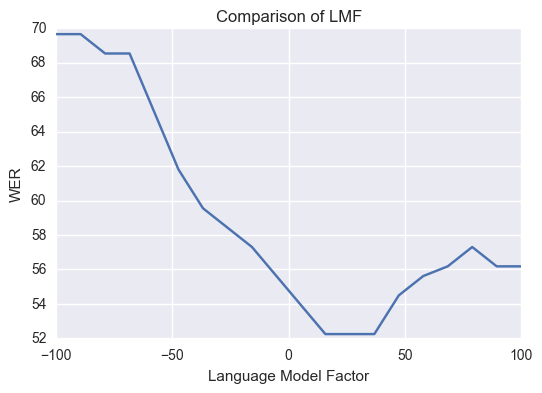

In [60]:
plot(WERs, lmfs)

## 2-gram

In [61]:
lm = arpa.loadf("LM/ukn.2.lm")[0]
df_probs = pd.DataFrame(data=probabilities)

In [62]:
depth, n = 3, 2
total_runs = 40
WERs, lmfs = [], np.linspace(-100, 100, total_runs)
start = timeit.default_timer()
for i, lmf in enumerate(lmfs):
    guesses = []
    for sentence_idx in test_set.sentences_index.values():
        # Catch probabilities of all possible combinations of words
        visual_graph = build_visual_graph(df_probs.loc[sentence_idx], depth, n)
        lm_graph = build_lm_graph(visual_graph, n)
        # Search the most possible combination
        best_guess, best_score = None, float("-inf")
        for sentence, visual_p in visual_graph.items():
            lm_p = lm_graph[sentence]
            score = visual_p + lmf * lm_p
            if score > best_score:
                best_guess = sentence[n-1:]
                best_score = score
        guesses += list(best_guess)
    if i % 5 == 0:
        print("Completed: {:.2f}%, Elapsed: {:.2f} sec".format((i+1.0)/total_runs*100,
                                                               timeit.default_timer() - start))
    WER = show_errors(guesses, test_set, 0)
    WERs.append(WER)

Completed: 2.50%, Elapsed: 30.49 sec
Completed: 15.00%, Elapsed: 169.16 sec
Completed: 27.50%, Elapsed: 311.94 sec
Completed: 40.00%, Elapsed: 451.85 sec
Completed: 52.50%, Elapsed: 593.62 sec
Completed: 65.00%, Elapsed: 738.16 sec
Completed: 77.50%, Elapsed: 878.15 sec
Completed: 90.00%, Elapsed: 1020.81 sec


Best LMF is 53.85, WER is 92.70%


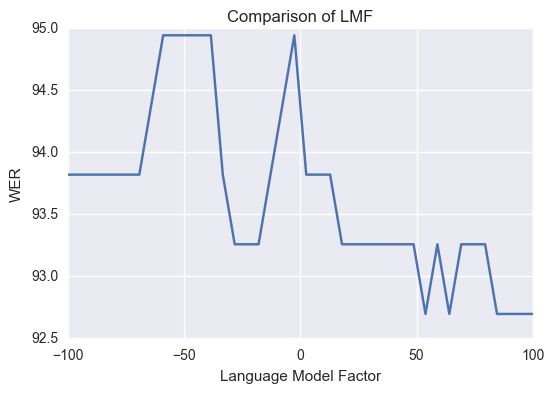

In [63]:
plot(WERs, lmfs)

## 3-gram

In [104]:
lm = arpa.loadf("LM/ukn.3.lm")[0]
df_probs = pd.DataFrame(data=probabilities)

In [105]:
depth, n = 3, 3
total_runs = 40
WERs, lmfs = [], np.linspace(-100, 100, total_runs)
start = timeit.default_timer()
for i, lmf in enumerate(lmfs):
    guesses = []
    for sentence_idx in test_set.sentences_index.values():
        # Catch probabilities of all possible combinations of words
        visual_graph = build_visual_graph(df_probs.loc[sentence_idx], depth, n)
        lm_graph = build_lm_graph(visual_graph, n)
        # Search the most possible combination
        best_guess, best_score = None, float("-inf")
        for sentence, visual_p in visual_graph.items():
            lm_p = lm_graph[sentence]
            score = visual_p + lmf * lm_p
            if score > best_score:
                best_guess = sentence[n-1:]
                best_score = score
        guesses += list(best_guess)
    if i % 5 == 0:
        print("Completed: {:.2f}%, Elapsed: {:.2f} sec".format((i+1.0)/total_runs*100,
                                                               timeit.default_timer() - start))
    WER = show_errors(guesses, test_set, 0)
    WERs.append(WER)

Completed: 2.50%, Elapsed: 61.18 sec
Completed: 15.00%, Elapsed: 336.48 sec
Completed: 27.50%, Elapsed: 591.50 sec
Completed: 40.00%, Elapsed: 845.32 sec
Completed: 52.50%, Elapsed: 1128.92 sec
Completed: 65.00%, Elapsed: 1383.44 sec
Completed: 77.50%, Elapsed: 1677.83 sec
Completed: 90.00%, Elapsed: 1961.64 sec


Best LMF is -7.69, WER is 89.33%


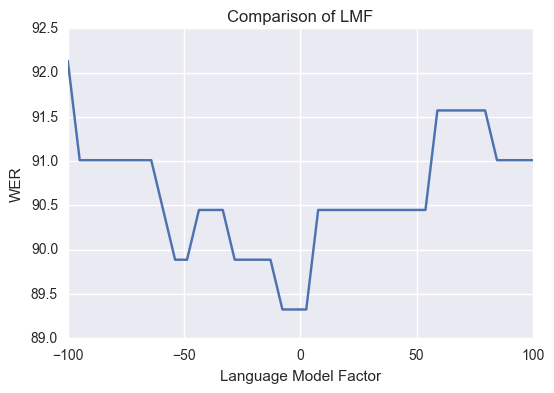

In [106]:
plot(WERs, lmfs)

## Results

In [110]:
WER_table = pd.DataFrame(columns=[ "WER", 'Best LMF'])
WER_table.loc['Without language model'] = ["50.56%", '']
WER_table.loc['1-gram'] = ["50.56%", '-15.79']
WER_table.loc['2-gram'] = ["89.33%", '-84.62']
WER_table.loc['3-gram'] = ["89.33%", '-7.69']
WER_table

,WER,Best LMF
Without language model,50.56%,
1-gram,50.56%,-15.79
2-gram,89.33%,-84.62
3-gram,89.33%,-7.69
